# DeepSeedlings: Pre-trained CNN with simple classifier

Using preprocessed images from DeepSeedlings-Part1. Using the pre-trained Keras Xception CNN (with the last layer 'cut' off), we ran the preprocessed images through the model to obtain Xception's vectorized representation for each image.

In this notebook, we build, train and validate simple classifiers as an MVP in order to build a pipeline that specializes in seedling species identification.

Better results were obtained in DeepSeedlings-Part2-CNN, where we used transfer learning to build a full Neural Network pipeline.

In [34]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
import keras
from keras import backend as K
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tqdm import tqdm
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold

In [6]:
from keras.applications import xception
from keras.models import Model

In [2]:
import pickle

In [23]:
def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = metrics.f1_score(ytest_, ytest, average = 'weighted')
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

In [37]:
def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(metrics.accuracy_score(ytest_, ytest)))
    print('Validation F1 Score: {}'.format(metrics.f1_score(ytest_, ytest, average = 'weighted')))
    print("\nConfusion Matrix")
    print(metrics.confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(metrics.classification_report(ytest_, ytest))

In [31]:
SEED = 1987

## Xception vectors

Load Xception's vectorized representation of each image.

In [3]:
train_x_bf = pickle.load( open( "train_x_bf.p", "rb" ) )
valid_x_bf = pickle.load( open( "valid_x_bf.p", "rb" ) )
ytr = pickle.load(open('ytr.p','rb'))
yv = pickle.load(open('yv.p','rb'))

### Logistic Regression

Best results out of the three simple classifiers I tried.

In [38]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)

In [39]:
best_clf, best_score = cross_validate(train_x_bf,ytr,logreg)
test_report(best_clf, valid_x_bf, yv)

fold 0, score: 0.863
fold 1, score: 0.811
fold 2, score: 0.814
fold 3, score: 0.781
fold 4, score: 0.809
fold 5, score: 0.800
fold 6, score: 0.785
fold 7, score: 0.763
fold 8, score: 0.806
fold 9, score: 0.800

Accuracy Score: 0.812
Validation F1 Score: 0.8135412124916558

Confusion Matrix
[[27  0  0  0  1  2  5  0  0  0  0  0]
 [ 0 31  0  0  0  1  0  1  0  2  1  1]
 [ 0  4 38  0  0  1  0  0  0  0  0  0]
 [ 0  1  1 42  0  2  0  0  3  3  0  1]
 [ 8  0  1  1 29  1  0  0  0  1  0  1]
 [ 1  0  2  0  0 35  0  0  0  1  0  1]
 [12  0  1  0  1  0 25  0  1  0  0  0]
 [ 0  1  0  1  0  1  0 40  1  0  0  0]
 [ 0  0  0  5  0  0  2  0 27  3  0  1]
 [ 0  1  0  1  0  0  0  0  7 39  1  0]
 [ 0  0  0  2  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  1  1  0  1  1  0  0 34]]

Classification Report
             precision    recall  f1-score   support

          0       0.56      0.77      0.65        35
          1       0.82      0.84      0.83        37
          2       0.88      0.88      0.88        43
    

### Random Forests

In [46]:
rf = RandomForestClassifier(n_estimators = 25)

In [47]:
best_clf, best_score = cross_validate(train_x_bf,ytr,rf)
test_report(best_clf, valid_x_bf, yv)

fold 0, score: 0.589
fold 1, score: 0.617
fold 2, score: 0.564
fold 3, score: 0.602
fold 4, score: 0.611
fold 5, score: 0.598
fold 6, score: 0.551
fold 7, score: 0.577
fold 8, score: 0.639
fold 9, score: 0.611

Accuracy Score: 0.597
Validation F1 Score: 0.6011368058558865

Confusion Matrix
[[26  0  0  1  3  1  6  1  0  0  0  0]
 [ 1 30  5  0  0  2  0  1  0  9  3  0]
 [ 0  0 29  2  1  8  0  1  3  5  1  0]
 [ 0  0  1 22  0  1  0  0  5  1  2  2]
 [ 8  0  0  0 23  2  4  3  1  1  1  1]
 [ 0  1  1  3  0 16  1  1  3  1  0  8]
 [13  0  0  3  1  0 20  0  2  1  0  0]
 [ 0  0  0  2  0  2  0 32  2  1  0  2]
 [ 0  2  0 11  3  2  1  1 20  5  0  0]
 [ 0  2  4  2  0  4  0  0  4 23  2  0]
 [ 0  3  3  5  0  2  0  0  0  2 33  1]
 [ 0  0  0  1  1  4  0  2  0  0  0 25]]

Classification Report
             precision    recall  f1-score   support

          0       0.54      0.68      0.60        38
          1       0.79      0.59      0.67        51
          2       0.67      0.58      0.62        50
    

In [51]:
from xgboost import XGBClassifier

In [53]:
xgb = XGBClassifier()

In [54]:
best_clf, best_score = cross_validate(train_x_bf,ytr,xgb)
test_report(best_clf, valid_x_bf, yv)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 0, score: 0.741


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 1, score: 0.715


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 2, score: 0.674


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 3, score: 0.725


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 4, score: 0.765


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 5, score: 0.742


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 6, score: 0.666


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 7, score: 0.731


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


fold 8, score: 0.745
fold 9, score: 0.768

Accuracy Score: 0.762
Validation F1 Score: 0.7652968884612183

Confusion Matrix
[[25  0  0  0  2  0  6  0  0  0  0  0]
 [ 0 31  1  0  0  1  0  1  0  3  0  1]
 [ 0  1 37  0  0  3  0  0  1  2  0  1]
 [ 0  0  1 37  0  2  0  0  4  1  1  2]
 [ 8  1  0  0 27  1  1  1  0  2  0  2]
 [ 0  0  1  1  1 29  0  0  0  0  0  4]
 [15  0  0  0  1  1 24  0  0  0  0  0]
 [ 0  0  0  0  0  2  0 40  0  0  1  2]
 [ 0  0  1  6  0  0  1  0 32  2  0  0]
 [ 0  3  1  3  0  3  0  0  3 33  0  0]
 [ 0  2  1  4  0  1  0  0  0  5 40  0]
 [ 0  0  0  1  1  1  0  0  0  1  0 27]]

Classification Report
             precision    recall  f1-score   support

          0       0.52      0.76      0.62        33
          1       0.82      0.82      0.82        38
          2       0.86      0.82      0.84        45
          3       0.71      0.77      0.74        48
          4       0.84      0.63      0.72        43
          5       0.66      0.81      0.73        36
          6  

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,abbreviation,class
0,BG,Black-grass
1,Ch,Charlock
2,Cl,Cleavers
3,CC,Common Chickweed
4,CW,Common wheat
5,FH,Fat Hen
6,LSB,Loose Silky-bent
7,M,Maize
8,SM,Scentless Mayweed
9,SP,Shepherds Purse


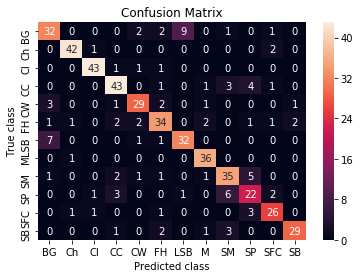

In [24]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax,  annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

In [25]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

794it [00:04, 159.66it/s]

test Images shape: (794, 299, 299, 3) size: 212,953,182


In [26]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

794/794 [==============================] - 546s 687ms/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112
